In [1]:
import numpy as np
import json
from pandas_datareader import data as pdr
import yfinance as yf
from cvxopt import matrix, solvers
from pyfinance.ols import OLS
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# display all columns
pd.set_option('display.max_columns', None)
# display all rows
pd.set_option('display.max_rows', None)

# Problem 1: Covariance Matrix Decomposition: 
Download historical data from your favorite source for 5 years and at least 100 companies or ETFs. In this problem we will
look at the covariance matrix for these assets and its properties.

1. Clean the data so that your input pricing matrix is as full as possible. Fill in any
gaps using a reasonable method of your choice. Explain why you chose that particular
method.

In [21]:
#problem 1
#1.1
sp500 = pdr.get_data_yahoo('^GSPC', start='2015-02-12', end='2020-02-12')
data = sp500.reset_index().loc[:, ['Date']]
with open("sp500-201501-components.json", 'r') as load_f:
    load_dict = json.load(load_f)
stk_list = load_dict['Symbols']
stk_list = stk_list[0:110]
for ticker in stk_list:
    try:
        stk = pdr.get_data_yahoo(ticker, start='2015-02-12', end='2020-02-12')
    except:
        #print('no ticker: ', ticker)
        stk_list.remove(ticker)
    else:
        if stk.empty!= True:
            stk = stk.reset_index().loc[:, ['Date', 'Close']]
            stk.rename(columns={'Close': ticker + '_Close'}, inplace=True)
            data = pd.DataFrame.merge(data, stk, how='left', on='Date')
data.dropna(axis=1, how='all', inplace=True)
values = dict([(col_name, col_mean) for col_name, col_mean in zip(data.columns.tolist(), data.mean().tolist())])
data.fillna(value=values, inplace=True)

2. Generate a sequence of daily returns for each asset for each date.

In [22]:
#1.2
for columns in data.columns.tolist()[1:]:
    data[columns[:-6] + '_daily_return'] = np.log(data[columns] / data[columns].shift(1))
    data.drop(columns=columns, inplace=True)
data.dropna(axis=0, how='any', inplace=True)

In [23]:
daily_return = data.drop(columns='Date')
corr = daily_return.corr()
cov = daily_return.cov()

3. Calculate the covariance matrix of daily returns and perform an eigenvalue decomposition on the matrix. How many positive eigenvalues are there? How many were negative? If any are negative, what happened?

In [24]:
def eigenvalue_decomposition(cov_martix):
    eigenvalue,eigenvector = np.linalg.eig(cov_martix)
    return eigenvalue,eigenvector

In [25]:
eigenvalue,eigenvector = eigenvalue_decomposition(cov.values)

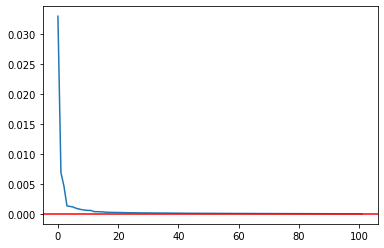

In [26]:
plt.plot(-np.sort(-eigenvalue))    
plt.axhline(y=0, c="red")
plt.show()

4. How many eigenvalues are required to account for 50% of the variance? How about 90%? Does this make sense to you?

In [27]:
def eigenvalue_for_variance(eigVals,percentage):
    descending = -np.sort(-eigVals)
    totalSum = sum(eigVals)
    localSum = 0
    num = 0
    for i in descending:
        localSum += i
        num += 1
        if localSum >= totalSum * percentage:
            return num

In [28]:
p50 = eigenvalue_for_variance(eigenvalue,0.5)

In [29]:
p50

1

In [30]:
p90 = eigenvalue_for_variance(eigenvalue,0.9)

In [31]:
p90

25

5. Using the number of eigenvalues in the 90% threshold above, create a return stream that represents the residual return after the principal components that correspond to these eigenvalues have been removed. Plot this return stream and comment on its properties.

In [40]:
def pca(dataMat,n):
    meanVal = 0
    newData = dataMat
    #meanVal=np.mean(dataMat,axis=0)
    #newData=dataMat-meanVal
    covMat=np.cov(dataMat,rowvar=0)
    eigVals,eigVects=np.linalg.eig(np.mat(covMat))
    eigValIndice=np.argsort(eigVals) # return inedx of each num in ranked order
    print(eigValIndice)
    n_eigValIndice=eigValIndice[-1:-(n+1):-1]
    print(n_eigValIndice)
    n_eigVect=eigVects[:,n_eigValIndice]
    HU = newData*n_eigVect
    #HUH = (HU*eigVects.T)+meanVal  
    return HU

In [41]:
a = pca(np.array(daily_return.values),p90)
re = np.sum(daily_return.values,axis=1)

[ 37  40  41  43  42  49  52  53  56  58  57  60  65  66  67  68  72  74
  75  76  81  94  87  88  95 101 100  96  97  93  91  90  99  98  86  84
  85  89  83  79  80  92  82  78  73  77  71  70  69  64  63  62  61  59
  55  54  51  50  48  47  46  45  44  39  38  36  35  34  33  32  31  30
  29  28  27  26  25  24  23  22  21  20  19  18  17  16  15  14  13  12
  11  10   9   8   7   6   5   4   3   2   1   0]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


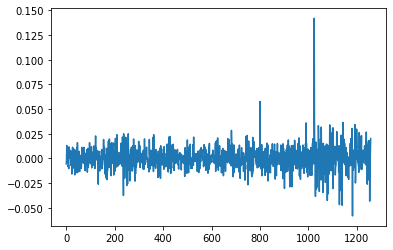

In [42]:
beta = np.linalg.inv(np.matrix(a.T)*np.matrix(a))*np.matrix(a.T)*(np.matrix(re).T)
ee = (np.matrix(re).T) - np.matrix(a)*np.matrix(beta)
plt.plot(ee)
plt.show()

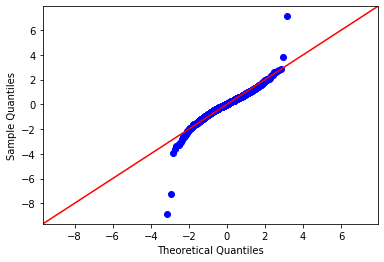

In [19]:
sm.qqplot(np.array(ee.flatten())[0], fit=True,line='45')
plt.show()

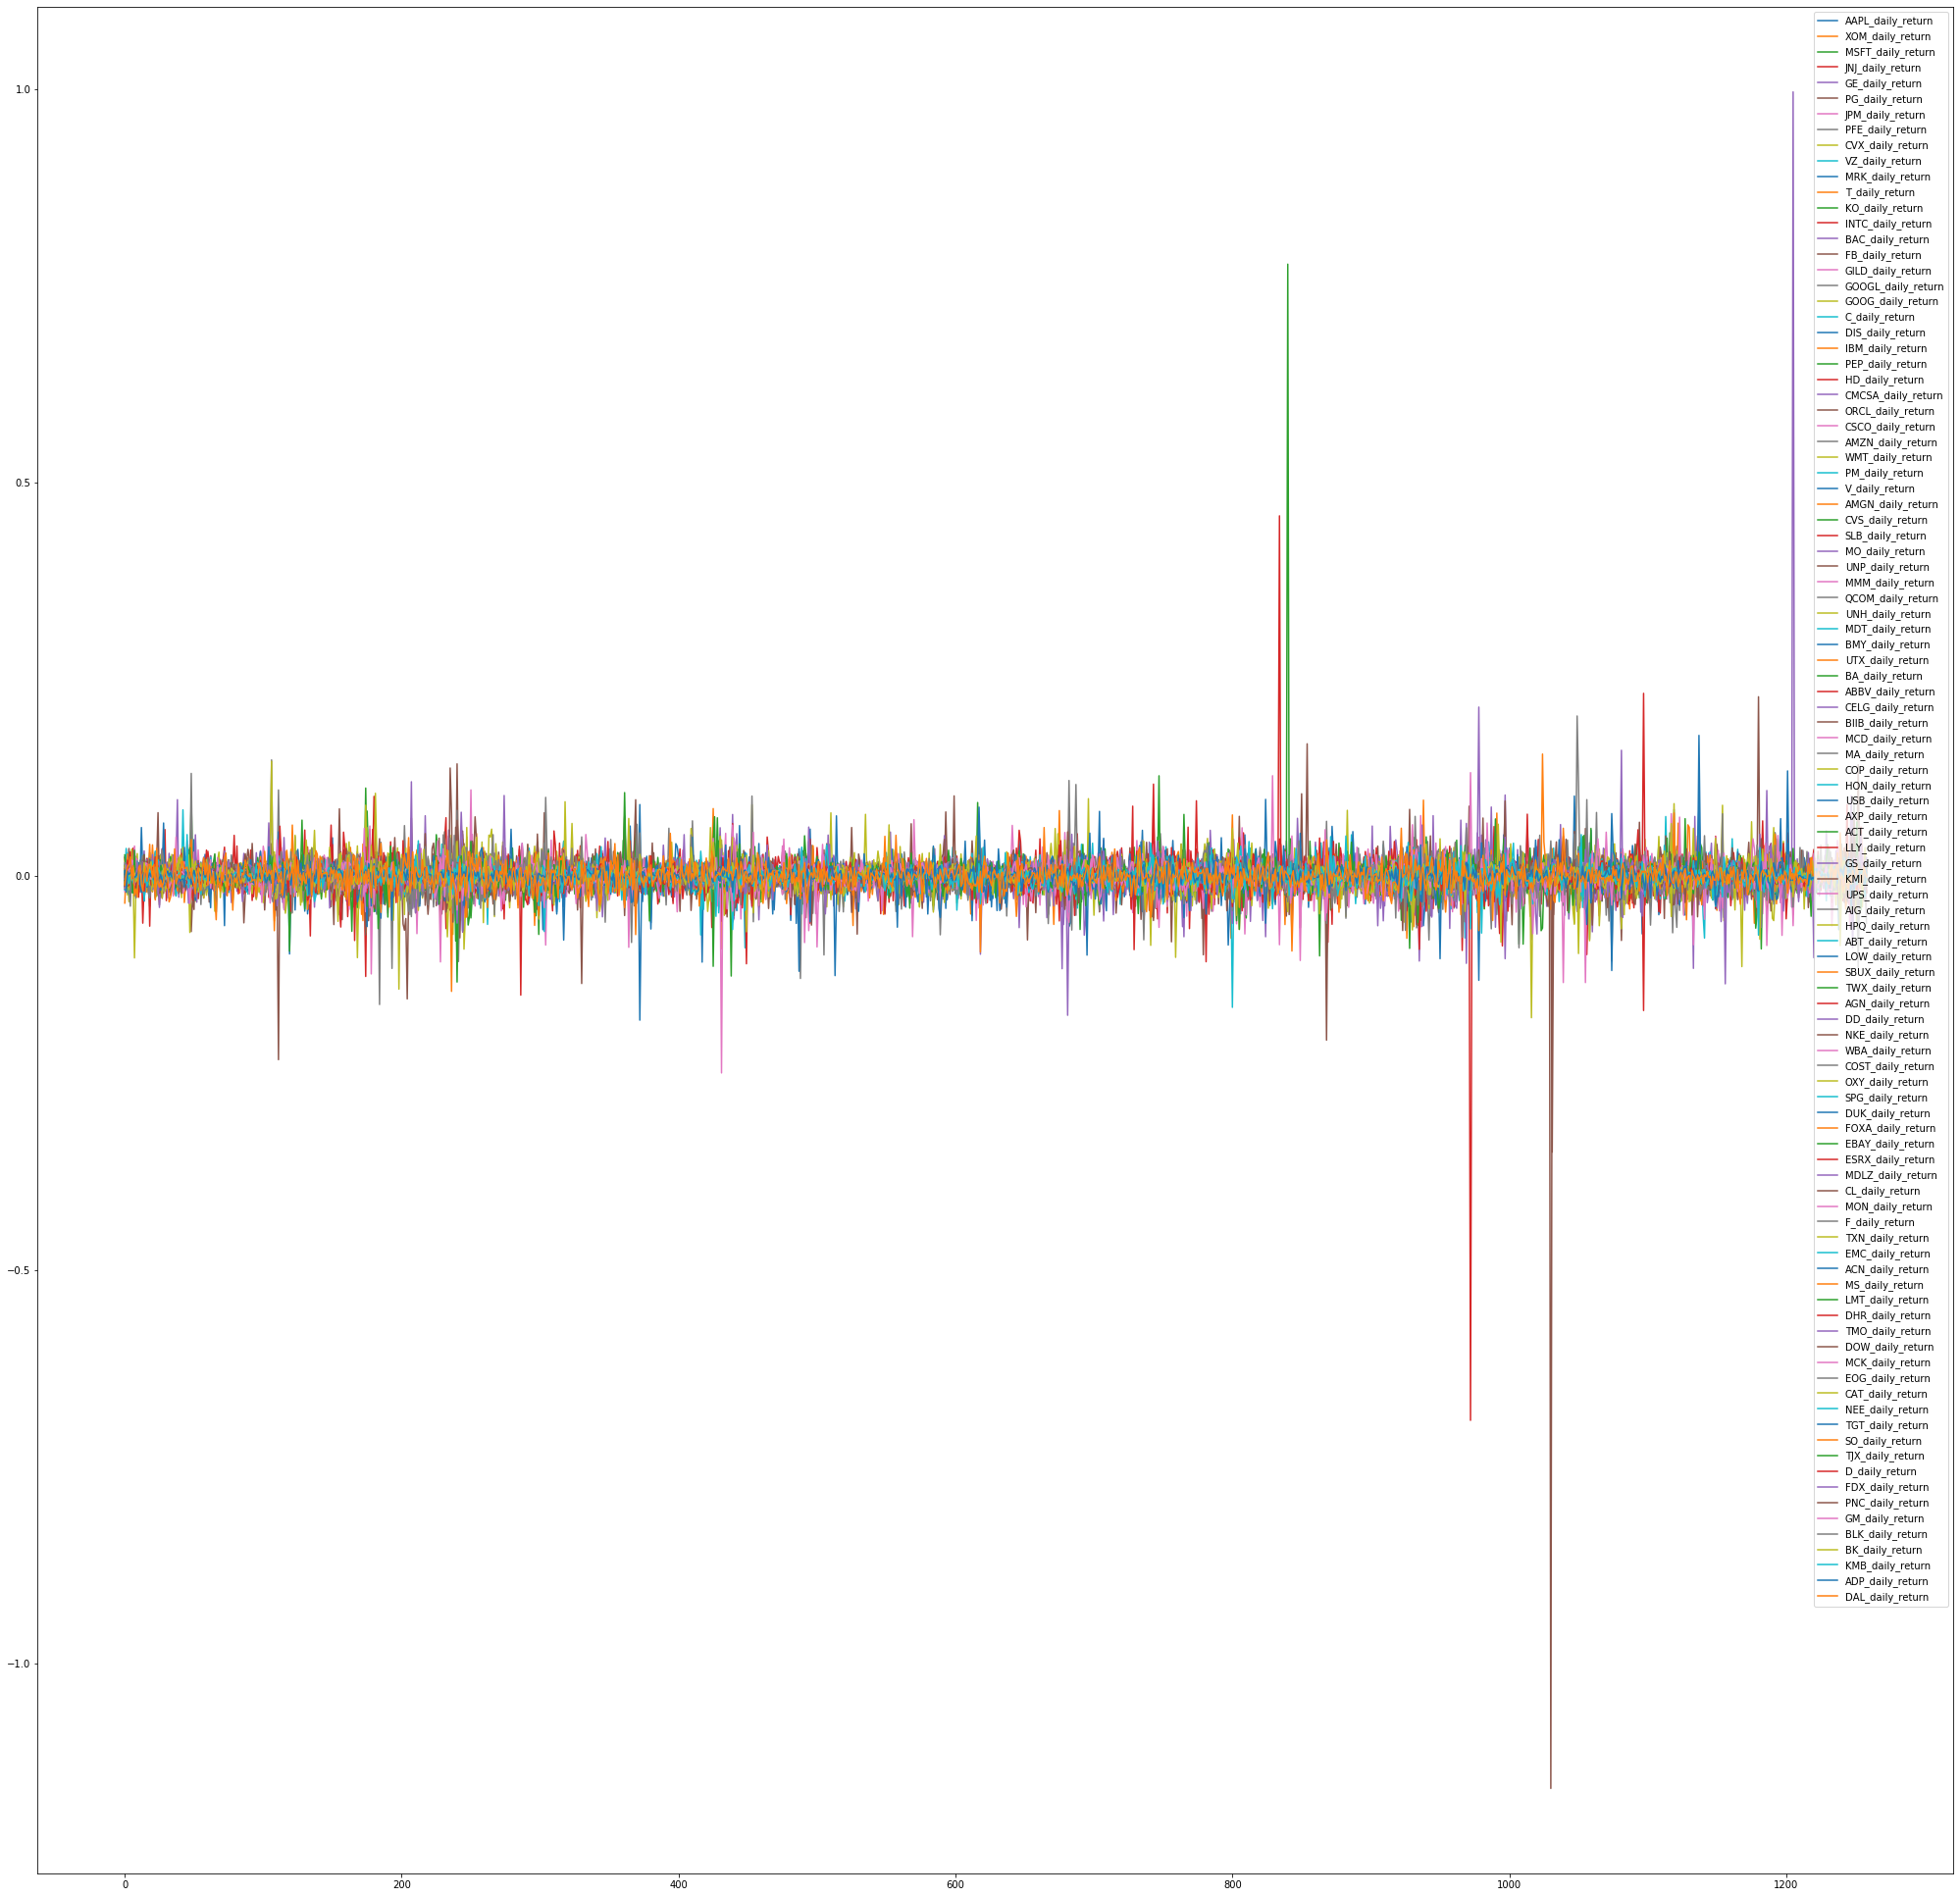

In [20]:
plt.figure(figsize=(35,35))
i = 0
while i < daily_return.shape[1]:
    r = daily_return.iloc[:,i].values
    beta = np.linalg.inv(np.matrix(a.T)*np.matrix(a))*np.matrix(a.T)*(np.matrix(r).T)
    ee = (np.matrix(r).T) - np.matrix(a)*np.matrix(beta)
    plt.plot(ee,label=daily_return.columns[i])
    i += 1
plt.legend()
plt.show()

# Problem 2: Portfolio Construction: 
In Lecture 7, we defined a Lagrangian for portfolio with constraints in matrix form by

$$
L(w, \lambda)=\langle R, w\rangle- a\langle w, C w\rangle-\langle\lambda, G w-c\rangle
$$

1. Form the matrix G by imposing the budget constraint, which is $\langle 1, w\rangle= 1$, and another constraint that allocates 10% of the portfolio to the first 17 securities (to simulate sector allocation). Using C from Problem 1, use your favorite method and the software
package of your choice to invert $G C^{-1} G^{T}$ in a nice, stable way. (Hint: consider my favorite method).

In [115]:
def portfolio_optimaztion(R, C, a=1):
    row,col = C.shape
    Q = a*(2*matrix(C))
    p = matrix(-1*R)
    G = matrix(-1*np.identity(col))
    h = matrix(np.zeros(shape=(col,1),dtype=float))
    A = np.zeros(shape=(2,col),dtype=float)
    A[0] = 1
    A[1][0:17] = 1
    A = matrix(A)
    b = np.zeros(shape=(2,1),dtype=float)
    b[0] = 1
    b[1] = 0.1
    b = matrix(b)
    Lambda = np.dot(np.linalg.inv(np.matrix(A)*np.linalg.inv(np.matrix(C))*np.matrix(A).T),-(2*a*b - np.matrix(A)*np.linalg.inv(np.matrix(C))*np.matrix(R).T))
    w = (np.linalg.inv(np.matrix(C))*(np.reshape(R,(R.shape[0],1)) - np.matrix(A).T*Lambda))/(2*a)
    sol = solvers.qp(P=Q,q=p,G=G,h=h,A=A,b=b)
    w1 = sol['x']
    return w,w1

In [116]:
annual_return = 252*daily_return.mean().values

In [117]:
annual_cov = 252*cov.values

In [118]:
w,w1 = portfolio_optimaztion(annual_return,annual_cov)

     pcost       dcost       gap    pres   dres
 0: -8.1188e-01 -1.3261e+00  1e+02  1e+01  9e+00
 1: -1.4470e-01 -1.2161e+00  3e+00  2e-01  1e-01
 2: -1.0274e-01 -5.6059e-01  5e-01  1e-15  2e-15
 3: -1.3570e-01 -3.1068e-01  2e-01  4e-17  1e-15
 4: -2.1939e-01 -3.2110e-01  1e-01  1e-16  7e-16
 5: -2.5993e-01 -2.7226e-01  1e-02  5e-16  1e-15
 6: -2.6887e-01 -2.6918e-01  3e-04  8e-16  8e-16
 7: -2.6914e-01 -2.6914e-01  3e-06  7e-16  8e-16
 8: -2.6914e-01 -2.6914e-01  3e-08  2e-16  1e-15
Optimal solution found.


2. What does the resulting portfolio look like? Would it be acceptable to most mutual funds? If not, what would you to do to fix that?

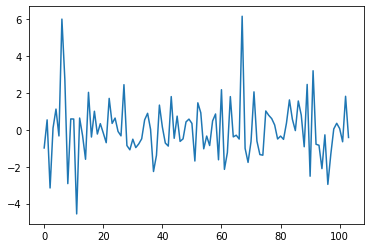

In [264]:
plt.plot(w)
plt.show()

In [120]:
print(w1)

[ 1.81e-09]
[ 1.43e-08]
[ 4.38e-10]
[ 9.89e-10]
[ 1.00e-01]
[ 1.90e-09]
[ 1.90e-09]
[ 1.95e-09]
[ 2.01e-09]
[ 1.02e-09]
[ 7.12e-10]
[ 5.19e-10]
[ 5.85e-10]
[ 8.01e-10]
[ 6.24e-10]
[ 1.32e-09]
[ 1.10e-09]
[ 1.54e-09]
[ 1.34e-09]
[ 6.99e-09]
[ 1.20e-09]
[ 1.62e-09]
[ 3.20e-09]
[ 9.72e-10]
[ 1.63e-09]
[ 1.22e-09]
[ 1.21e-09]
[ 1.22e-08]
[ 7.62e-10]
[ 7.51e-10]
[ 9.50e-10]
[ 1.44e-09]
[ 4.34e-10]
[ 1.40e-09]
[ 1.20e-09]
[ 2.46e-07]
[ 9.31e-10]
[ 7.75e-10]
[ 5.50e-10]
[ 6.77e-09]
[ 1.48e-09]
[ 6.26e-10]
[ 9.32e-10]
[ 1.95e-09]
[ 5.95e-10]
[ 3.12e-09]
[ 1.04e-09]
[ 4.86e-10]
[ 2.18e-09]
[ 8.41e-10]
[ 1.32e-09]
[ 1.06e-09]
[ 3.06e-09]
[ 2.39e-09]
[ 5.75e-10]
[ 1.62e-09]
[ 7.36e-10]
[ 2.85e-09]
[ 6.66e-09]
[ 9.44e-10]
[ 3.70e-09]
[ 1.02e-09]
[ 7.88e-10]
[ 4.20e-09]
[ 6.63e-10]
[ 6.22e-10]
[ 6.24e-10]
[ 6.19e-08]
[ 1.47e-09]
[ 6.61e-10]
[ 1.62e-09]
[ 5.45e-09]
[ 1.95e-09]
[ 4.91e-10]
[ 1.39e-09]
[ 4.37e-08]
[ 6.80e-10]
[ 6.70e-01]
[ 2.30e-01]
[ 5.67e-10]
[ 9.13e-10]
[ 1.56e-09]
[ 1.97e-09]
[ 2.

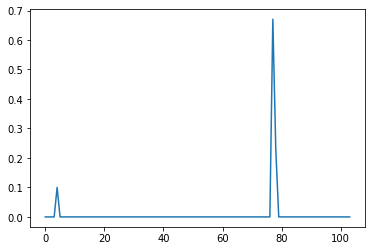

In [259]:
plt.plot(w1)
plt.show()